In [1]:
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from directory_tree import display_tree
from qcodes import Instrument, ManualParameter, Parameter, validators
from scipy.optimize import minimize_scalar

import quantify_core.data.handling as dh
from quantify_core.analysis import base_analysis as ba
from quantify_core.analysis import cosine_analysis as ca
from quantify_core.measurement import Gettable, MeasurementControl
from quantify_core.utilities.dataset_examples import mk_2d_dataset_v1
from quantify_core.utilities.examples_support import (
    default_datadir,
    mk_cosine_instrument,
)
from quantify_core.utilities.inspect_utils import display_source_code

dh.set_datadir(default_datadir())
meas_ctrl = MeasurementControl("meas_ctrl")

Data will be saved in:
/home/slavoutich/quantify-data


In [2]:
mw_source1 = Instrument("mw_source1")
# NB: for brevity only, this not the proper way of adding parameters to QCoDeS instruments
mw_source1.freq = ManualParameter(
    name="freq",
    label="Frequency",
    unit="Hz",
    vals=validators.Numbers(),
    initial_value=1.0,
)

pulsar_QRM = Instrument("pulsar_QRM")
# NB: for brevity only, this not the proper way of adding parameters to QCoDeS instruments
pulsar_QRM.signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: mw_source1.freq() * 1e-8
)

In [3]:
meas_ctrl.settables(
    mw_source1.freq
)  # We want to set the frequency of a microwave source
meas_ctrl.setpoints(np.arange(5e9, 5.2e9, 100e3))  # Scan around 5.1 GHz
meas_ctrl.gettables(pulsar_QRM.signal)  # acquire the signal from the pulsar QRM
dset = meas_ctrl.run(name="Frequency sweep")  # run the experiment

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

In [4]:
t = ManualParameter("time", label="Time", unit="s")


class WaveGettable:
    """An examples of a gettable."""

    def __init__(self):
        self.unit = "V"
        self.label = "Amplitude"
        self.name = "sine"

    def get(self):
        """Return the gettable value."""
        return np.sin(t() / np.pi)

    def prepare(self) -> None:
        """Optional methods to prepare can be left undefined."""
        print("Preparing the WaveGettable for acquisition.")

    def finish(self) -> None:
        """Optional methods to finish can be left undefined."""
        print("Finishing WaveGettable to wrap up the experiment.")


# verify compliance with the Gettable format
wave_gettable = WaveGettable()
Gettable(wave_gettable)

In [5]:
t = ManualParameter(
    "time",
    label="Time",
    unit="s",
    vals=validators.Numbers(),  # accepts a single number, e.g. a float or integer
)


class DualWave1D:
    """Example of a "dual" gettable."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Sine Amplitude", "Cosine Amplitude"]
        self.name = ["sin", "cos"]

    def get(self):
        """Return the value of the gettable."""
        return np.array([np.sin(t() / np.pi), np.cos(t() / np.pi)])

    # N.B. the optional prepare and finish methods are omitted in this Gettable.


# verify compliance with the Gettable format
wave_gettable = DualWave1D()
Gettable(wave_gettable)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 5

100% completed | elapsed time:      0s | time left:      0s  last batch size:      3  
100% completed | elapsed time:      0s | time left:      0s  last batch size:      3  

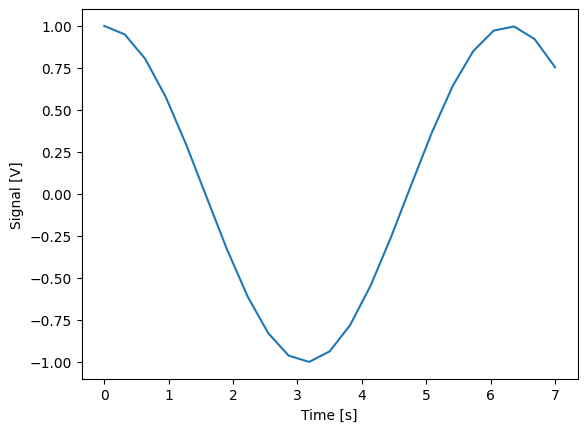

In [6]:
time = ManualParameter(
    name="time",
    label="Time",
    unit="s",
    vals=validators.Arrays(),  # accepts an array of values
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)

time.batched = True
time.batch_size = 5
signal.batched = True
signal.batch_size = 10

meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
meas_ctrl.setpoints(np.linspace(0, 7, 23))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot()

In [7]:
with tempfile.TemporaryDirectory() as tmpdir:
    old_dir = dh.get_datadir()
    dh.set_datadir(Path(tmpdir) / "quantify-data")
    # we generate a dummy dataset and a few empty dirs for pretty printing
    (Path(dh.get_datadir()) / "20210301").mkdir()
    (Path(dh.get_datadir()) / "20210428").mkdir()

    quantify_dataset = mk_2d_dataset_v1()
    ba.BasicAnalysis(dataset=quantify_dataset).run()
    # to make sure the full path is displayed
    print(display_tree(dh.get_datadir(), string_rep=True), end="")
    dh.set_datadir(old_dir)

quantify-data/
├── 20210301/
├── 20210428/
└── 20230926/
    └── 20230926-194517-639-5bd4b0-my experiment/
        ├── analysis_BasicAnalysis/
        │   ├── dataset_processed.hdf5
        │   ├── figs_mpl/
        │   │   ├── Line plot x0-y0.png
        │   │   ├── Line plot x0-y0.svg
        │   │   ├── Line plot x1-y0.png
        │   │   └── Line plot x1-y0.svg
        │   └── quantities_of_interest.json
        └── dataset.hdf5


<xarray.Dataset>
Dimensions:  (dim_0: 1000)
Coordinates:
    x0       (dim_0) float64 -1.0 -0.7778 -0.5556 -0.3333 ... 0.5556 0.7778 1.0
    x1       (dim_0) float64 0.0 0.0 0.0 0.0 0.0 ... 10.0 10.0 10.0 10.0 10.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 -1.0 -0.7778 -0.5556 ... -0.4662 -0.6526 -0.8391
Attributes:
    tuid:                      20230926-194517-639-5bd4b0
    name:                      my experiment
    grid_2d:                   True
    grid_2d_uniformly_spaced:  True
    xlen:                      10
    ylen:                      100

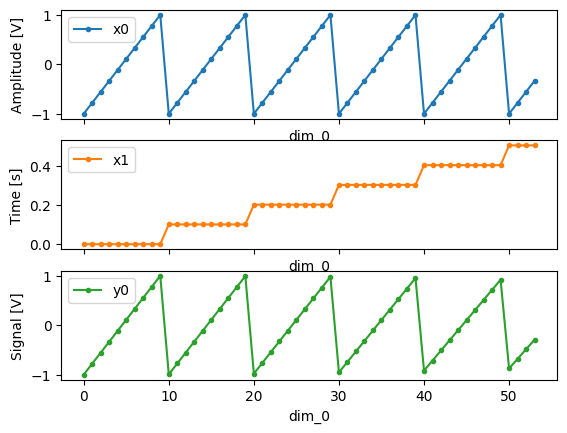

In [8]:
# plot the columns of the dataset
_, axs = plt.subplots(3, 1, sharex=True)
xr.plot.line(quantify_dataset.x0[:54], label="x0", ax=axs[0], marker=".")
xr.plot.line(quantify_dataset.x1[:54], label="x1", ax=axs[1], color="C1", marker=".")
xr.plot.line(quantify_dataset.y0[:54], label="y0", ax=axs[2], color="C2", marker=".")
tuple(ax.legend() for ax in axs)
# return the dataset
quantify_dataset

<xarray.Dataset>
Dimensions:  (x0: 10, x1: 100)
Coordinates:
  * x0       (x0) float64 -1.0 -0.7778 -0.5556 -0.3333 ... 0.5556 0.7778 1.0
  * x1       (x1) float64 0.0 0.101 0.202 0.303 0.404 ... 9.697 9.798 9.899 10.0
Data variables:
    y0       (x0, x1) float64 -1.0 -0.9949 -0.9797 ... -0.9312 -0.8897 -0.8391
Attributes:
    tuid:                      20230926-194517-639-5bd4b0
    name:                      my experiment
    grid_2d:                   False
    grid_2d_uniformly_spaced:  True
    xlen:                      10
    ylen:                      100

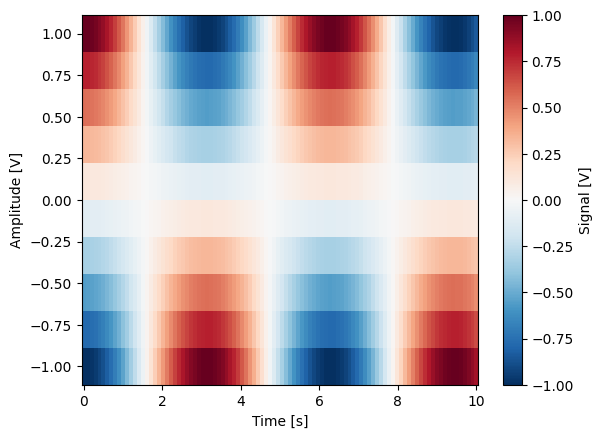

In [9]:
gridded_dset = dh.to_gridded_dataset(quantify_dataset)
gridded_dset.y0.plot()
gridded_dset

In [10]:
display_source_code(mk_cosine_instrument)

def mk_cosine_instrument() -> Instrument:
    """A container of parameters (mock instrument) providing a cosine model."""

    instr = Instrument("ParameterHolder")

    # ManualParameter's is a handy class that preserves the QCoDeS' Parameter
    # structure without necessarily having a connection to the physical world
    instr.add_parameter(
        "amp",
        initial_value=0.5,
        unit="V",
        label="Amplitude",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "freq",
        initial_value=1,
        unit="Hz",
        label="Frequency",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "t", initial_value=1, unit="s", label="Time", parameter_class=ManualParameter
    )
    instr.add_parameter(
        "phi",
        initial_value=0,
        unit="Rad",
        label="Phase",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "noise_level",
        initial_value=0.05,
        unit="V",
        label="Noise level",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "acq_delay", initial_value=0.02, unit="s", parameter_class=ManualParameter
    )

    def cosine_model():
        sleep(instr.acq_delay())  # simulates the acquisition delay of an instrument
        return (
            cos_func(instr.t(), instr.freq(), instr.amp(), phase=instr.phi(), offset=0)
            + np.random.randn() * instr.noise_level()
        )

    # Wrap our function in a Parameter to be able to associate metadata to it, e.g. unit
    instr.add_parameter(
        name="sig", label="Signal level", unit="V", get_cmd=cosine_model
    )

    return instr

In [11]:
pars = mk_cosine_instrument()
meas_ctrl.settables(pars.t)
meas_ctrl.setpoints(np.linspace(0, 2, 50))
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("Cosine experiment")
dataset

Starting iterative measurement...
  2% completed | elapsed time:      0s | time left:      1s  

 52% completed | elapsed time:      0s | time left:      0s  

100% completed | elapsed time:      1s | time left:      0s  
100% completed | elapsed time:      1s | time left:      0s  

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 0.0 0.04082 0.08163 0.1224 ... 1.918 1.959 2.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.4427 0.4202 0.4573 0.2919 ... 0.4737 0.3959 0.528
Attributes:
    tuid:                             20230926-194519-516-fe8f1e
    name:                             Cosine experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

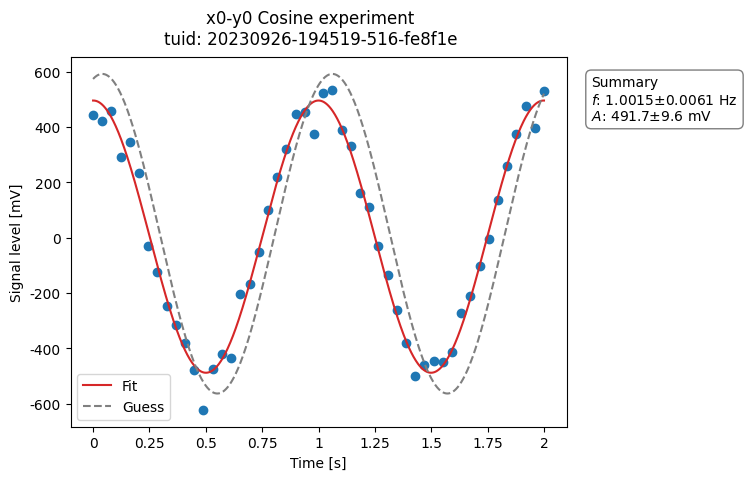

In [12]:
a_obj = ca.CosineAnalysis(label="Cosine experiment")
a_obj.run()  # execute the analysis.
a_obj.display_figs_mpl()  # displays the figures created in previous step.

In [13]:
experiment_container_path = dh.locate_experiment_container(tuid=dataset.tuid)
print(display_tree(experiment_container_path, string_rep=True), end="")

20230926-194519-516-fe8f1e-Cosine experiment/
├── analysis_CosineAnalysis/
│   ├── dataset_processed.hdf5
│   ├── figs_mpl/
│   │   ├── cos_fit.png
│   │   └── cos_fit.svg
│   ├── fit_results/
│   │   └── cosine.txt
│   └── quantities_of_interest.json
├── dataset.hdf5
└── snapshot.json


In [14]:
# for example, the fitted frequency and amplitude are stored
freq = a_obj.quantities_of_interest["frequency"]
amp = a_obj.quantities_of_interest["amplitude"]
print(f"frequency {freq}")
print(f"amplitude {amp}")

frequency 1.001+/-0.006
amplitude 0.492+/-0.010


In [15]:
display_source_code(ba.BasicAnalysis)

class BasicAnalysis(BaseAnalysis):
    """
    A basic analysis that extracts the data from the latest file matching the label
    and plots and stores the data in the experiment container.
    """

    def create_figures(self):
        """
        Creates a line plot x vs y for every data variable yi and coordinate xi in the
        dataset.
        """

        # NB we do not use `to_gridded_dataset` because that can potentially drop
        # repeated measurement of the same x0_i setpoint (e.g., AllXY experiment)
        dataset = self.dataset
        # for compatibility with older datasets
        # in case "x0" is not a coordinate we use "dim_0"
        coords = list(dataset.coords)
        dims = list(dataset.dims)
        plot_against = coords if coords else (dims if dims else [None])
        for idx, xi in enumerate(plot_against):
            for yi, yvals in dataset.data_vars.items():
                # for compatibility with older datasets, do not plot "x0" vs "x0"
                if yi.startswith("y"):
                    fig, ax = plt.subplots()

                    fig_id = f"Line plot x{idx}-{yi}"

                    yvals.plot.line(ax=ax, x=xi, marker=".")

                    adjust_axeslabels_SI(ax)

                    qpl.set_suptitle_from_dataset(fig, self.dataset, f"x{idx}-{yi}")

                    # add the figure and axis to the dicts for saving
                    self.figs_mpl[fig_id] = fig
                    self.axs_mpl[fig_id] = ax

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

<xarray.Dataset>
Dimensions:  (x0: 20)
Coordinates:
  * x0       (x0) float64 0.0 0.3684 0.7368 1.105 ... 5.895 6.263 6.632 7.0
Data variables:
    y0       (x0) float64 1.0 0.9329 0.7406 0.4489 ... 0.9998 0.9399 0.7539
Attributes:
    tuid:                             20230926-194521-660-4220d2
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

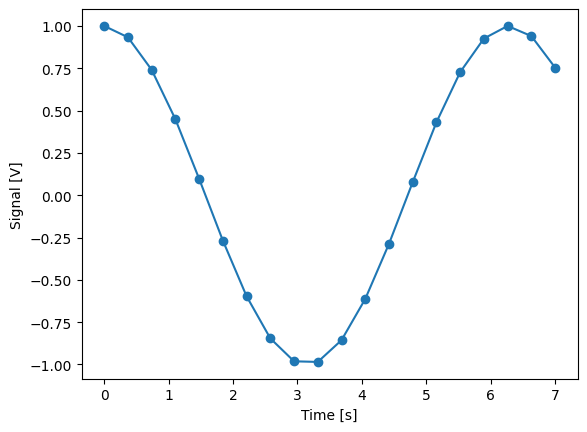

In [16]:
time = ManualParameter(
    name="time", label="Time", unit="s", vals=validators.Numbers(), initial_value=1
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)

meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
meas_ctrl.setpoints(np.linspace(0, 7, 20))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(marker="o")
dset_grid

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

<xarray.Dataset>
Dimensions:  (x0: 10, x1: 12)
Coordinates:
  * x0       (x0) float64 0.0 0.5556 1.111 1.667 2.222 ... 3.333 3.889 4.444 5.0
  * x1       (x1) float64 0.0 0.4545 0.9091 1.364 ... 3.636 4.091 4.545 5.0
Data variables:
    y0       (x0, x1) float64 1.5 1.788 2.241 2.955 ... 167.4 178.3 195.5 222.6
Attributes:
    tuid:                             20230926-194521-916-a44111
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10
    ylen:                             12

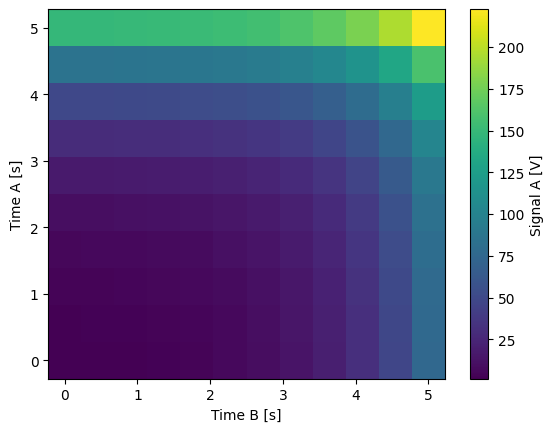

In [17]:
time_a = ManualParameter(
name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
name="time_b", label="Time B", unit="s", vals=validators.Numbers(), initial_value=1
)
signal = Parameter(
name="sig_a",
label="Signal A",
unit="V",
get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)

meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables(signal)
meas_ctrl.setpoints_grid([np.linspace(0, 5, 10), np.linspace(5, 0, 12)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(cmap="viridis")
dset_grid

Running adaptively...


/home/slavoutich/.local/opt/conda/envs/doc_qc064/lib/python3.9/site-packages/quantify_core/data/handling.py:1240: RuntimeWarning: overflow encountered in square
  diff_square = np.square(linspace[1:-1] - points[1:-1])
/home/slavoutich/.local/opt/conda/envs/doc_qc064/lib/python3.9/site-packages/quantify_core/data/handling.py:1241: RuntimeWarning: overflow encountered in square
  if np.any(diff_square > np.square(abs_tolerance)):


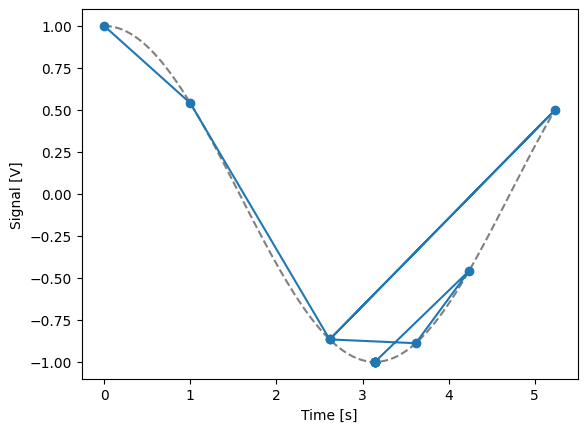

In [18]:
time = ManualParameter(
    name="time", label="Time", unit="s", vals=validators.Numbers(), initial_value=1
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)
meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
dset = meas_ctrl.run_adaptive("1D minimizer", {"adaptive_function": minimize_scalar})

dset_ad = dh.to_gridded_dataset(dset)
# add a grey cosine for reference
x = np.linspace(np.min(dset_ad["x0"]), np.max(dset_ad["x0"]), 101)
y = np.cos(x)
plt.plot(x, y, c="grey", ls="--")
_ = dset_ad.y0.plot(marker="o")

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

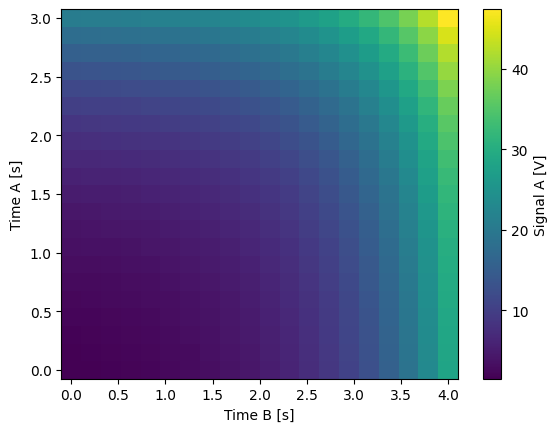

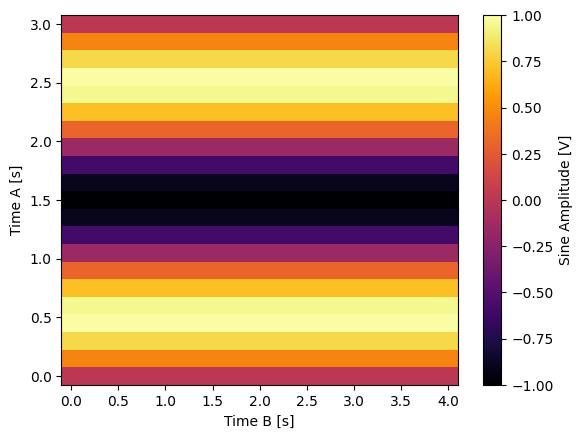

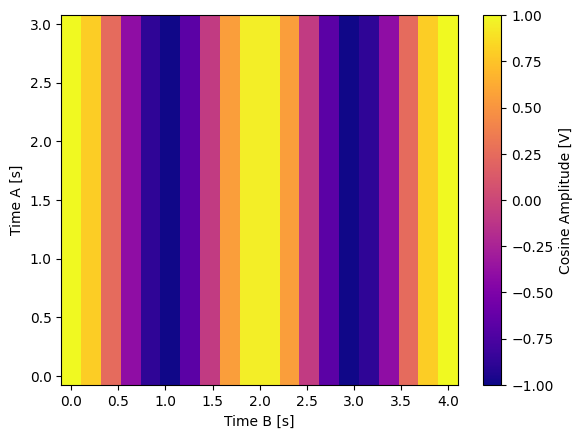

<xarray.Dataset>
Dimensions:  (x0: 21, x1: 20)
Coordinates:
  * x0       (x0) float64 0.0 0.15 0.3 0.45 0.6 0.75 ... 2.4 2.55 2.7 2.85 3.0
  * x1       (x1) float64 0.0 0.2105 0.4211 0.6316 ... 3.368 3.579 3.789 4.0
Data variables:
    y0       (x0, x1) float64 1.5 1.617 1.762 1.94 ... 34.6 38.0 42.2 47.38
    y1       (x0, x1) float64 0.0 0.0 0.0 0.0 ... 3.674e-16 3.674e-16 3.674e-16
    y2       (x0, x1) float64 1.0 0.7891 0.2455 -0.4017 ... 0.2455 0.7891 1.0
Attributes:
    tuid:                             20230926-194522-396-00bd89
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  True
    xlen:                             21
    ylen:                             20

In [19]:
time_a = ManualParameter(
    name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
    name="time_b", label="Time B", unit="s", vals=validators.Numbers(), initial_value=1
)

signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)


class DualWave2D:
    """A "dual" gettable example that depends on two settables."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Sine Amplitude", "Cosine Amplitude"]
        self.name = ["sin", "cos"]

    def get(self):
        """Returns the value of the gettable."""
        return np.array([np.sin(time_a() * np.pi), np.cos(time_b() * np.pi)])


dual_wave = DualWave2D()
meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables([signal, dual_wave])
meas_ctrl.setpoints_grid([np.linspace(0, 3, 21), np.linspace(4, 0, 20)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

for yi, cmap in zip(("y0", "y1", "y2"), ("viridis", "inferno", "plasma")):
    dset_grid[yi].plot(cmap=cmap)
    plt.show()
dset_grid

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 20

100% completed | elapsed time:      0s | time left:      0s  last batch size:     20  
100% completed | elapsed time:      0s | time left:      0s  last batch size:     20  
NOTE: The gettable returns an array:

[ 1.          0.93289715  0.7405942   0.4488993   0.09695955 -0.26799272
 -0.59697884 -0.84584701 -0.98119769 -0.98486606 -0.8563598  -0.61292518
 -0.28723252  0.07700839  0.43091433  0.72698911  0.92549782  0.99979946
  0.93992232  0.75390225]


<xarray.Dataset>
Dimensions:  (x0: 20)
Coordinates:
  * x0       (x0) float64 0.0 0.3684 0.7368 1.105 ... 5.895 6.263 6.632 7.0
Data variables:
    y0       (x0) float64 1.0 0.9329 0.7406 0.4489 ... 0.9998 0.9399 0.7539
Attributes:
    tuid:                             20230926-194523-091-e64930
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

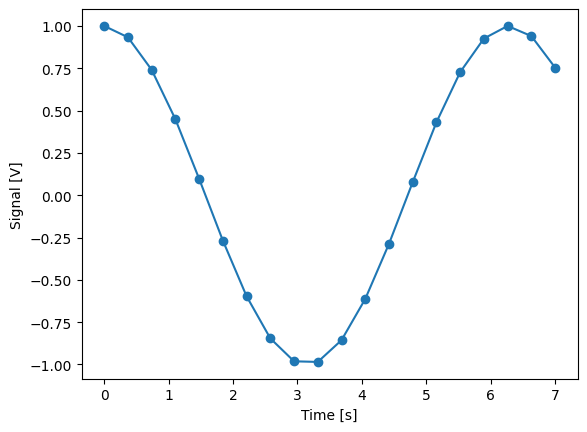

In [20]:
time = ManualParameter(
    name="time",
    label="Time",
    unit="s",
    vals=validators.Arrays(),
    initial_value=np.array([1, 2, 3]),
)
signal = Parameter(
    name="sig_a", label="Signal", unit="V", get_cmd=lambda: np.cos(time())
)

time.batched = True
signal.batched = True

meas_ctrl.settables(time)
meas_ctrl.gettables(signal)
meas_ctrl.setpoints(np.linspace(0, 7, 20))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(marker="o")
print(f"\nNOTE: The gettable returns an array:\n\n{signal.get()}")
dset_grid

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 time_a 
Batched settable(s):
	 time_b 
Batch size limit: 12

100% completed | elapsed time:      0s | time left:      0s  last batch size:     12  
100% completed | elapsed time:      0s | time left:      0s  last batch size:     12  

<xarray.Dataset>
Dimensions:  (x0: 10, x1: 12)
Coordinates:
  * x0       (x0) float64 0.0 0.5556 1.111 1.667 2.222 ... 3.333 3.889 4.444 5.0
  * x1       (x1) float64 0.0 0.3636 0.7273 1.091 ... 2.909 3.273 3.636 4.0
Data variables:
    y0       (x0, x1) float64 1.5 1.719 2.035 2.488 ... 157.6 161.6 167.4 175.7
Attributes:
    tuid:                             20230926-194523-347-529783
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10
    ylen:                             12

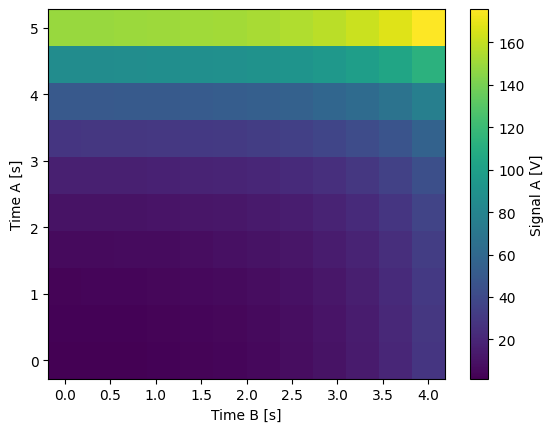

In [21]:
time_a = ManualParameter(
    name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
    name="time_b",
    label="Time B",
    unit="s",
    vals=validators.Arrays(),
    initial_value=np.array([1, 2, 3]),
)
signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)

time_b.batched = True
time_b.batch_size = 12
signal.batched = True

meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables(signal)
# `setpoints_grid` will take into account the `.batched` attribute
meas_ctrl.setpoints_grid([np.linspace(0, 5, 10), np.linspace(4, 0, time_b.batch_size)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

dset_grid.y0.plot(cmap="viridis")
dset_grid

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 100

100% completed | elapsed time:      0s | time left:      0s  last batch size:    100  
100% completed | elapsed time:      0s | time left:      0s  last batch size:    100  

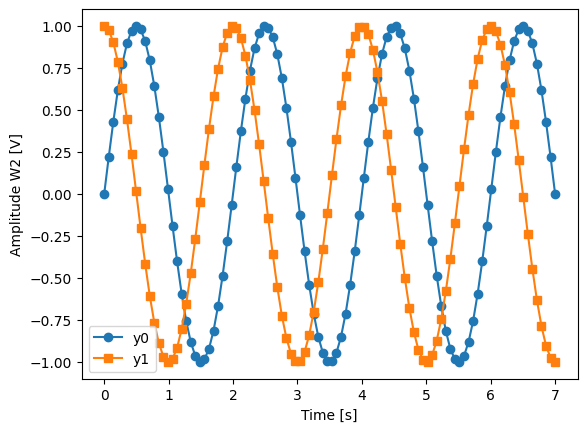

In [22]:
time = ManualParameter(
    name="time",
    label="Time",
    unit="s",
    vals=validators.Arrays(),
    initial_value=np.array([1, 2, 3]),
)


class DualWaveBatched:
    """A "dual" batched gettable example."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Amplitude W1", "Amplitude W2"]
        self.name = ["sine", "cosine"]
        self.batched = True
        self.batch_size = 100

    def get(self):
        """Returns the value of the gettable."""
        return np.array([np.sin(time() * np.pi), np.cos(time() * np.pi)])


time.batched = True
dual_wave = DualWaveBatched()

meas_ctrl.settables(time)
meas_ctrl.gettables(dual_wave)
meas_ctrl.setpoints(np.linspace(0, 7, 100))
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

_, ax = plt.subplots()
dset_grid.y0.plot(marker="o", label="y0", ax=ax)
dset_grid.y1.plot(marker="s", label="y1", ax=ax)
_ = ax.legend()